## Import Libraries

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Load Data

In [181]:
data= pd.read_csv('data/tecator.csv')

In [182]:
print("Data shape: ", data.shape)
data.head()

Data shape:  (215, 103)


,850 nm,852 nm,854 nm,856 nm,858 nm,860 nm,862 nm,864 nm,866 nm,868 nm,...,1038 nm,1040 nm,1042 nm,1044 nm,1046 nm,1048 nm,1050 nm,fat,water,protein
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5,60.5,16.7
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1,46.0,13.5
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4,71.0,20.5
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9,72.8,20.7
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5,58.3,15.5


In [183]:
spectra, content = data.iloc[:, :-3].to_numpy(), data.iloc[:, -3:]
print(spectra.shape)
print(content.shape)

(215, 100)
(215, 3)


## Data Visualization

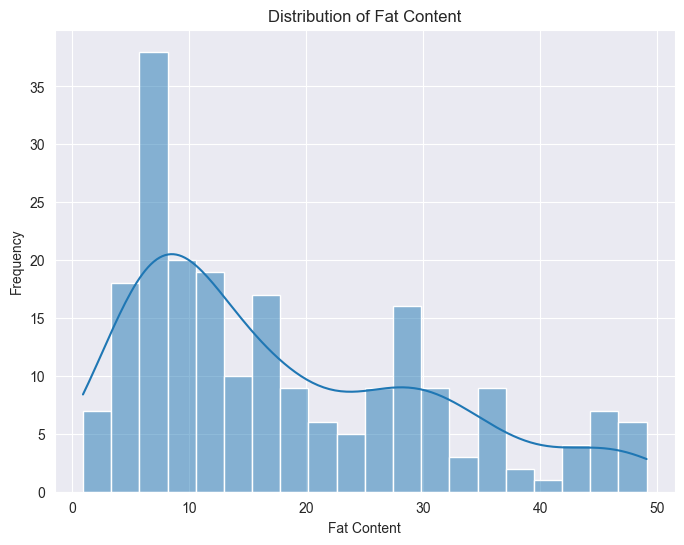

In [184]:
plt.figure(figsize=(8, 6))
sns.histplot(data['fat'], bins=20, kde=True)
plt.title('Distribution of Fat Content')
plt.xlabel('Fat Content')
plt.ylabel('Frequency')
plt.show()

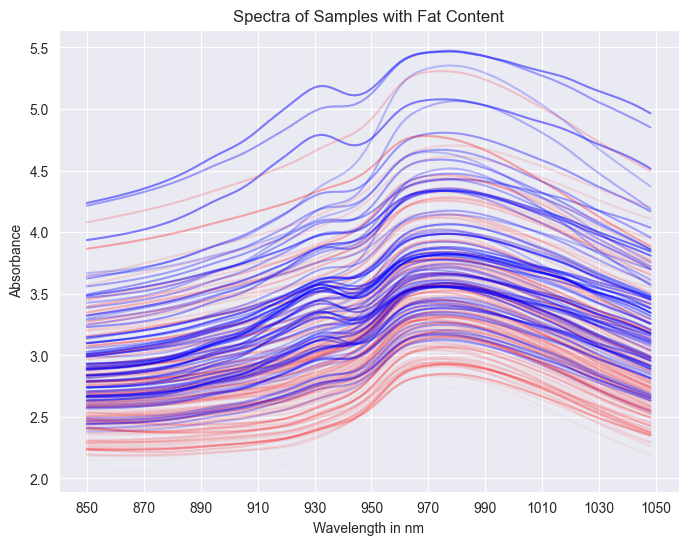

In [185]:
plt.figure(figsize=(8, 6))
for row, spectrum in enumerate(spectra):
    alpha = content.iloc[row]['fat'] / 100
    plt.plot(spectrum, alpha=alpha, color='blue' if alpha > 0.2 else 'red')

plt.xlabel("Wavelength in nm")
plt.ylabel("Absorbance")

plt.xticks(np.arange(0, 101, 10), [int(x) for x in np.linspace(850, 1050, 11)])
plt.title("Spectra of Samples with Fat Content")
plt.show()

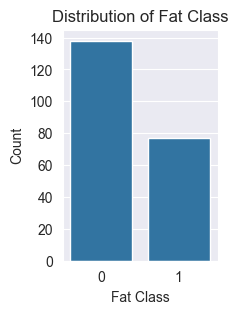

In [186]:
# Define the target variable
data['label'] = (data['fat'] > 20).astype(int)  # 1 for high-fat, 0 for low-fat
# Visualize the target class distribution
plt.figure(figsize=(2, 3))
sns.countplot(x='label', data=data)
plt.title('Distribution of Fat Class')
plt.xlabel('Fat Class')
plt.ylabel('Count')
plt.show()

## Feature Engineering and Preprocessing

In [187]:
# Separate features and target label
X = data.drop(['label','fat','protein','water'], axis=1)  # or only spectra columns if they are differently named
y = data['label']
print(y.value_counts())

label
0    138
1     77
Name: count, dtype: int64


In [188]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [189]:
models = {
    'Perceptron': Perceptron(),
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}
# Evaluate models using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name} - Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})')

Perceptron - Accuracy: 0.8891 (+/- 0.0731)
Logistic Regression - Accuracy: 0.9531 (+/- 0.0301)
Random Forest - Accuracy: 0.8254 (+/- 0.0498)
SVM - Accuracy: 0.7150 (+/- 0.0573)


## Hyperparameter Tuning

In [190]:
# Hyperparameter tuning
param_grid = {
    'Perceptron': {
        'penalty': [None, 'l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'max_iter': [1000, 2000, 3000]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto',0.1],
        'kernel': ['linear', 'rbf']
    }
}
best_estimators = {}

for name, param in param_grid.items():
    grid_search = GridSearchCV(models[name], param, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best cross-validation accuracy for {name}: {grid_search.best_score_:.4f}')
    best_estimators[name] = grid_search.best_estimator_

Best parameters for Perceptron: {'alpha': 0.0001, 'max_iter': 1000, 'penalty': 'l1'}
Best cross-validation accuracy for Perceptron: 0.9533
Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Best cross-validation accuracy for Logistic Regression: 0.9709
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy for Random Forest: 0.8313
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy for SVM: 0.9709


In [191]:
# Evaluate models using cross-validation
for name, model in best_estimators.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name} - Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})')

Perceptron - Accuracy: 0.9533 (+/- 0.0238)
Logistic Regression - Accuracy: 0.9709 (+/- 0.0259)
Random Forest - Accuracy: 0.8370 (+/- 0.0550)
SVM - Accuracy: 0.9709 (+/- 0.0259)


## Test Evaluation

In [192]:
# Evaluate the best model on the test set
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    print(f'Test accuracy for {name}: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Classification report for {name}:\n {classification_report(y_test, y_pred)}')

Test accuracy for Perceptron: 0.9767
Classification report for Perceptron:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.93      0.97        15

    accuracy                           0.98        43
   macro avg       0.98      0.97      0.97        43
weighted avg       0.98      0.98      0.98        43

Test accuracy for Logistic Regression: 1.0000
Classification report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        15

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43

Test accuracy for Random Forest: 0.7907
Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.85      0.82      

In [193]:
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'{name} Confusion Matrix:\n', conf_matrix)
    print(f'{name} Unique predictions:', np.unique(y_pred))

Perceptron Confusion Matrix:
 [[28  0]
 [ 1 14]]
Perceptron Unique predictions: [0 1]
Logistic Regression Confusion Matrix:
 [[28  0]
 [ 0 15]]
Logistic Regression Unique predictions: [0 1]
Random Forest Confusion Matrix:
 [[23  5]
 [ 4 11]]
Random Forest Unique predictions: [0 1]
SVM Confusion Matrix:
 [[28  0]
 [ 0 15]]
SVM Unique predictions: [0 1]
